In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(42)

In [55]:
linear_func = lambda x, m: m * x
nx = 7
xs = np.linspace(-5, 9, nx)
m_true = 2.3
y_true = linear_func(xs, m_true)
y_dists = []
for mu in y_true:
    # add random noise to the true values
    mu = mu + np.random.normal(0, 1)
    std = np.random.uniform(1, 5)
    sample = np.random.normal(mu, std, size=10000)
    #plt.hist(sample, bins=50, density=True)
    #plt.show()
    y_dists.append(sample)

y = np.array(y_dists)

with open('x_y.pkl', 'wb') as f:
    pickle.dump((xs, y), f)

In [56]:
with open('x_y.pkl', 'rb') as f:
    xs, y = pickle.load(f)

In [57]:
mus = y.mean(axis=1)
stds = y.std(axis=1)

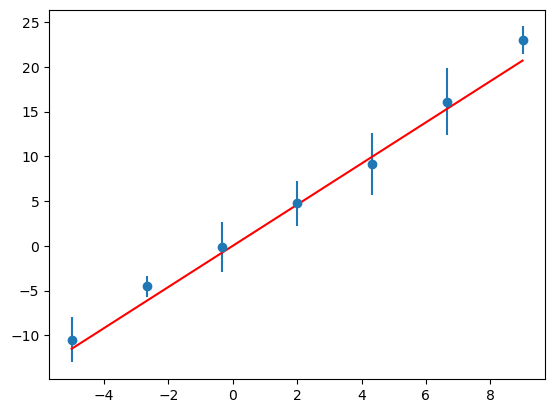

In [58]:
plt.errorbar(xs, mus, yerr=stds, fmt='o');
plt.plot(xs, linear_func(xs, m_true), color='red', label='m=1');

Best fit m: 2.40 +0.14 -0.14


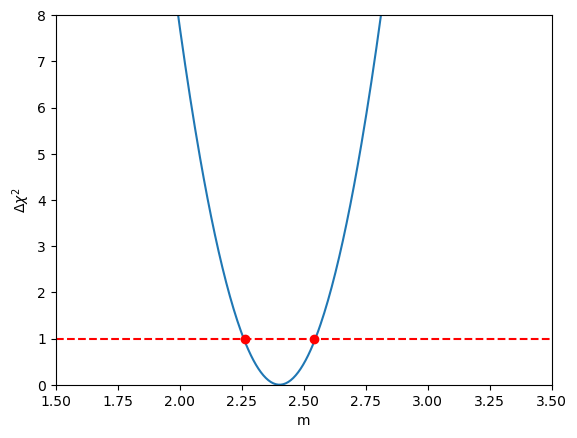

In [90]:
def chisquare(x, y, yerr, m):
    return np.sum(((y - linear_func(x, m)) / yerr) ** 2)

ms = np.linspace(0, 5, 1000)

chis = np.array([chisquare(xs, mus, stds, m) for m in ms])
delta_chis = chis - chis.min()

# get best
m_best = ms[delta_chis == 0][0]

# get points at which the delta chi squared is 1
ml, mr = ms[delta_chis <= 1][[0, -1]]

up_unc = mr - m_best
down = m_best - ml

print(f'Best fit m: {m_best:.2f} +{up_unc:.2f} -{down:.2f}')

plt.plot(ms, delta_chis);
plt.axhline(1, color='red', linestyle='--');
plt.plot([ml, mr], [1, 1], 'o', color='red');
plt.ylim(0, 8);
plt.xlim(1.5, 3.5);
plt.xlabel('m');
plt.ylabel('$\Delta \chi^2$');

In [105]:
# formulae for m and error from theory

m_best_theory = np.mean(xs*mus) / np.mean(xs**2)
#std_theory = np.sqrt(np.mean(stds**2) / (np.mean(xs**2) * nx))
std_theory = np.sqrt(np.sum(1 / stds**2) / (np.sum(1 / stds**2) * np.sum(xs**2 / stds**2) - (np.sum(xs / stds**2))**2)) 
print(f'Theory: m={m_best_theory:.2f} +/- {std_theory:.2f}')

Theory: m=2.37 +/- 0.20
